# Loading wikipedia bios

## loading raw identities

In [27]:
import pandas as pd
from ast import literal_eval


df = pd.read_csv('FinalDataFrame5.csv')
df.identities = df.identities.apply(literal_eval)
bios = list(df['identities'])

bios[:5]

[['rapper'],
 ['minister', 'Bible scholar', 'author'],
 ['astrophysicist'],
 ['snooker', 'billiards player'],
 ['Welsh sports journalist']]

In [10]:
pd.set_option("max_colwidth", None)
df.iloc[1:2]

,name_searched,context,identities
1,Renita J. Weems,"Renita J. Weems is an ordained minister, a Hebrew Bible scholar, and an author.","[minister, Bible scholar, author]"


In [ ]:
# The rest is similar to twitter bios approach

# Loading twitter bios

## load all raw data

In [31]:
import pickle
with open('/user/smadani/navid/data/pis2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    

# PI frequency and top PIs

In [32]:
from collections import Counter
cntr = Counter()

for bio in bios:
    cntr.update(bio)

print(len(bios))

15459872


In [12]:
import numpy as np

freqs = list(cntr.values())
print(f"percentile freq: {np.percentile(freqs, 90)} mean freq: {np.mean(freqs)}")

percentile freq: 9.0 mean freq: 28.606337144830846


In [14]:
most_frequent_pis = {k:v for k,v in cntr.items() if v > 10}
len(most_frequent_pis)

5106

In [115]:
import pandas as pd

df = pd.DataFrame({'pi': list(most_frequent_pis.keys()), 'cnt': list(most_frequent_pis.values())})
df = df.sort_values(by=['cnt'], ascending=False)

In [116]:
df.to_csv('wiki_most_frequent_pis.csv', index=False, header=True)

In [118]:
!head twitter_most_frequent_pis.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
pi,cnt
she,452418
her,397756
he,185793
him,154092
they,127571
fan account,124627
blacklivesmatter,101217
blm,101082
ig,93961


### most frequent neighbors

In [ ]:
from tqdm import tqdm
neighbor_cnt = {}

for bio in tqdm(bios):
    for pi in bio:
        if pi in most_frequent_pis:
            if pi not in neighbor_cnt:
                neighbor_cnt[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in most_frequent_pis]
            neighbor_cnt[pi].update(rest)

print(len(neighbor_cnt))            

#post processing and pruning empty adjacencies

for pi, adj in neighbor_cnt.copy().items():
    if len(adj) < 2:
        neighbor_cnt.pop(pi)
    
print(f"size after pruning: {len(neighbor_cnt)}")        

### calculating tf-idf

In [ ]:
for pi, neighs in tqdm(neighbor_cnt.items()):
    for phrase in neighs.keys():
        neighs[phrase] /= most_frequent_pis[phrase]
        

### calculating using bi-partite method

In [ ]:
from scipy import sparse, io

pi_idx = {}
for pi in most_frequent_pis:
    pi_idx[pi] = len(pi_idx)

#creating bipartite matrix
usr_pi = []

for bio in bios:
    cur_usr_pis = []
    for pi in bio:
        if pi in most_frequent_pis:
            cur_usr_pis.append(pi_idx[pi])
    if len(cur_usr_pis) < 2:
        continue
    usr_pi.append(cur_usr_pis)
    

print(f"original users: {len(bios)}")
print(f"no of users after pruning: {len(usr_pi)}")


In [ ]:
usrs = []
pis = []
scores = []

for uid, pis in enumerate(usr_pi):
    for pi in pis:
        usrs.append(uid)
        pis.append(pi)
        scores.append(1)

In [ ]:
%% time

BP_MATRIX_FILENAME = "./bipartite_pi.mtx"
output_matrix = sparse.coo_matrix((scores, (usrs, pis)))
io.mmwrite(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
!du -hs ./bipartite_pi.mtx

In [ ]:
from scipy import io

io.mmread(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
scores

In [ ]:
!rm ./bipartite_pi.mtx.gz
!gzip ./bipartite_pi.mtx
!ls

In [ ]:
import sys

sys.path.append("../bipartite-pairs/python-scoring/")
import score_data

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
score_data.score_only(
    BP_MATRIX_FILENAME+".gz",
    ['weighted_corr_exp'],
    BP_SCORING_OUTPUT,
)

In [ ]:
!zcat ./bipartite_output.csv.gz

In [ ]:
import pandas as pd

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
df = pd.read_csv(BP_SCORING_OUTPUT)
df.head()

In [ ]:
# recreate the neighboring dictionary



### save 

In [ ]:
import pandas as pd

pis = []
positives = []
negatives = []

for pi, cntr in tqdm(neighbor_cnt.items()):
    cur_neg = [x for x in most_frequent_pis if x not in neighbor_cnt[pi]]
    if len(cur_neg) > 20:
        cur_neg = list(np.random.choice(cur_neg, size=20, replace=False))
    cur_pos = [x[0] for x in neighbor_cnt[pi].most_common(5)]
    if len(cur_neg) < 4 or len(neighbor_cnt[pi])<2:
        print(f"PASSING PI: {pi}")
        continue
    positives.append(cur_pos)
    pis.append(pi)
    negatives.append(cur_neg)
                 
print(f"saving {len(pis)} pis")
df = pd.DataFrame({'pis': pis, 'positives': positives, 'negatives': negatives})
df.to_csv('twitter_pi_with_neighbors_tfidf.csv', index=False, header=True)

In [ ]:
!wc -l wiki_pi_with_neighbors_standard.csv

In [ ]:
!head wiki_pi_with_neighbors_standard.csv

## create train and test dataset

In [33]:
from sklearn.model_selection import train_test_split

lower_bios = []
for bio in bios:
    lower_bio = []
    for pi in bio:
        lower_bio.append(pi.lower())
    lower_bios.append(lower_bio)
    
train, test = train_test_split(lower_bios, test_size=0.2, shuffle=True)
print(len(train), len(test))



12367897 3091975


In [34]:
import pickle

dataset = 'twitter'

with open(f'./data/{dataset}_test_bios.pkl', 'wb') as f:
    pickle.dump(test, f)
    
with open(f'./data/{dataset}_train_bios.pkl', 'wb') as f:
    pickle.dump(train, f)

# Cleaning data

## phrase cleaning

In [67]:
import pickle

dataset = 'twitter'
min_freq = 10 if dataset == 'wiki' else 500

print(min_freq)
with open(f'./data/{dataset}_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)

500


In [68]:
# build a vocabulary of phrases
from tqdm import tqdm_notebook as tqdm
from collections import Counter

pi_cnt = Counter()
for bio in tqdm(bios):
    pi_cnt.update(bio)

len(pi_cnt)

/scratch/12250815/ipykernel_12332/2665102249.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bio in tqdm(bios):


  0%|          | 0/12367897 [00:00<?, ?it/s]

7860996

In [46]:
pi_cnt.most_common(10)

[('footballer', 87629),
 ('politician', 59687),
 ('actor', 24498),
 ('actress', 22208),
 ('writer', 20656),
 ('professor', 19977),
 ('author', 19583),
 ('member', 19326),
 ('football player', 17436),
 ('singer', 16542)]

In [47]:
pi_cnt.most_common(len(pi_cnt))[-5:]

[('lokoja', 1),
 ('usa pageant', 1),
 ('state coroner', 1),
 ('trinidad soccer', 1),
 ('film technician', 1)]

## cleaning each bio

In [70]:
from tqdm import tqdm

# phrases of lenght at least m
# profiles with at least k phrases
# pis that's been repeated at least m times in dataset

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= min_freq:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_bios = clean_pis(bios)
print(len(cleaned_bios), len(bios))

100%|██████████| 12367897/12367897 [00:27<00:00, 452224.60it/s]


2753951 12367897


## saving cleaned dataset

In [71]:
with open(f'./data/{dataset}_cleaned_train_bios.pkl', 'wb') as f:
    pickle.dump(cleaned_bios, f)

# Masked Language Modeling

## loading dataset

In [1]:
import pickle

with open('/user/smadani/navid/data/bios2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    
bios[100:150]

['UX, communication + design; tiptoeing through fields of hubris',
 'Taca y programar.',
 "The best of SBS entertainment, sport, drama, news, documentaries & more. Celebrating the world's diverse stories.",
 'Researching urban communication, emergent publics, and methods for integrating culture and design.',
 'Owner and founder of Heart Spade PR; Co-host @MemoriesMixtape; Instagram lead @persistbrooklyn; Dog walker @nyanimalrescue. (he/him)',
 "I'm a Writer. I fly spaceships. Sometimes I fight rubber monsters. I talk about TV/Movies/Music/VideoGames I enjoy as well. Lets talk. I Reply a lot. :)",
 'random internet stranger',
 'Actor, Comedian, Asian Girl Lover, Boob Expert, Video Gamer, Jedi Atheist Falcons Fan',
 'Bringing you all the latest entertainment news! \nKeep up at http://eonline.com and watch us weekdays from NYC at 7am!',
 'LISTEN UP YO, THIS IS HOT GYAL BIZNESS! Check out my latest on http://mixcloud.com/msmanya',
 'Lackwit gadabout, Software Engineer (@gitlab), 🏍 blogger,

## cleaning dataset

In [ ]:
from tqdm import tqdm
import re

## remove url and email addresses + social media links
cleaned_bios = []

for description in tqdm(bios):
    d = re.sub(r'\w+@\w+\.\w+', '', description.lower()).strip()
    d = re.sub(r'(on )?(snapchat|snap|ig|insta|instagram|email|phone): +[A-Za-z0-9_@.-]+', " ", d).strip()
    d = re.sub(r'http\S+', '', d).strip()
    d = d.replace("&emsp;", "").replace("&nbsp;", "")
    d = re.sub(r"\s+", " ", d).strip()
    if len(d) > 5:
        cleaned_bios.append(d)

len(cleaned_bios), cleaned_bios[:10]

 16%|█▌        | 2518661/16240577 [00:43<03:51, 59201.14it/s]

## domain adaptation

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


model_checkpoint = "bert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# Contrastive learning

## generating positive negative samples

In [115]:
import pickle

dataset = 'twitter'
    
with open(f'./data/{dataset}_cleaned_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)
    
pi_set = set()
for bio in bios:
    pi_set.update(bio)
pi_set = list(pi_set)
    
len(bios), len(pi_set)

(2753951, 4750)

In [112]:
np.median([len(x) for x in bios])

3.0

### neighbors of a PI

In [116]:
from tqdm import tqdm
neighbors = {}

for bio in tqdm(bios):
    for pi in bio:
        if pi in pi_cnt:
            if pi not in neighbors:
                neighbors[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in pi_cnt]
            neighbors[pi].update(rest)

print(len(neighbors))            


100%|██████████| 2753951/2753951 [00:19<00:00, 140517.89it/s]

4750


### pos/neg samples

In [117]:
from random import randint
import numpy as np

def pair_in_list(current_pair, l):
    for pair in l:
        if current_pair[0] in pair and current_pair[1] in pair:
            return True
    return False


def generate_triplets(bios, k=3):
    samples = []
    for idx, bio in tqdm(enumerate(bios), total=len(bios)):
        if len(bio) != len(set(bio)):
            continue
        iters = min(len(bio)-1, k)
        chosen_pis = []
        for i in range(iters):
            pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            while pair_in_list([pos1,pos2], chosen_pis):
                pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            chosen_pis.append([pos1, pos2])
            neg_idx = randint(0, len(pi_set)-1)
            while pi_set[neg_idx] in neighbors[pos1] or pi_set[neg_idx] in neighbors[pos2]:
                neg_idx = randint(0, len(pi_set)-1)
            samples.append([pos1, pos2, pi_set[neg_idx]])
    return samples

triplets = generate_triplets(bios, k=3)

100%|██████████| 2753951/2753951 [03:06<00:00, 14739.46it/s]


In [118]:
print(len(triplets))

5056795


## save dataset

In [119]:
import pickle 

with open(f'data/{dataset}-triplets.pkl', 'wb') as f:
    pickle.dump(triplets, f)

In [120]:
import pickle 

dataset = 'twitter'

with open(f'data/{dataset}-triplets.pkl', 'rb') as f:
    triplets = pickle.load(f)

In [121]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(triplets, test_size=0.02, shuffle=True)

print(f"train size: {len(train_set)}, validation size: {len(valid_set)}")

train size: 4955659, validation size: 101136


In [122]:
import csv

# writing the data into the file
with open(f'data/{dataset}-valid.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(valid_set)
    
with open(f'data/{dataset}-train.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(train_set)


## finetuning

### building the dataset


In [123]:
import csv
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

with open(f'data/{dataset}-train.csv', newline='') as f:
    train_examples = []
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        train_examples.append(InputExample(texts=[row[0], row[1]], label=1.0))
        train_examples.append(InputExample(texts=[row[0], row[2]], label=0.0))
    

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
4955659it [00:50, 97187.43it/s] 


### loading evaluation dataset

In [124]:

from sentence_transformers import evaluation

with open(f'data/{dataset}-valid.csv', newline='') as f:
    sent1s = []
    sent2s = []
    scores = []
    i = 0
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        sent1s.append(row[0])
        sent1s.append(row[0])
        sent2s.append(row[1])
        sent2s.append(row[2])
        scores.append(1.0)
        scores.append(0.0)
        i += 1
evaluator = evaluation.EmbeddingSimilarityEvaluator(sent1s, sent2s, scores)


101136it [00:00, 760854.01it/s]


### creating data loaders

In [125]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
dense_model = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())
model.add_module('3', dense_model)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=256)
train_loss = losses.CosineSimilarityLoss(model)

model

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
  (3): Dense({'in_features': 384, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

### training

In [ ]:
output_model_path = f'models/miniLM-L6-{dataset}-out256'

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=10,
          evaluation_steps=2500,
          warmup_steps=5000,
          output_path=output_model_path)

/projects/academic/kjoseph/navid/workspace/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38717 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration:   0%|          | 0/38717 [00:00<?, ?it/s]

Iteration:   0%|          | 0/38717 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration:   0%|          | 0/38717 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### valiation results - best model


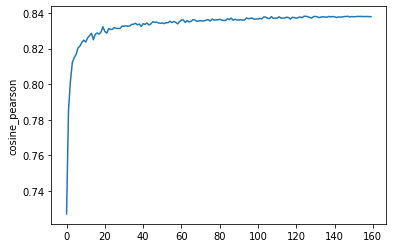

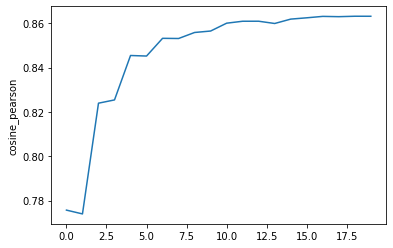

In [138]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

twitter_valid = pd.read_csv('models/miniLM-L6-twitter-out256/eval/similarity_evaluation_results.csv')
wiki_valid = pd.read_csv('models/miniLM-L6-wiki-out256/eval/similarity_evaluation_results.csv')

sns.lineplot(x=range(len(twitter_valid)), y=twitter_valid['cosine_pearson'])
plt.show()
sns.lineplot(x=range(len(wiki_valid)), y=wiki_valid['cosine_pearson'])
plt.show()

## evaluation

### loading saved model

In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [ ]:
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer('./models/miniLM-L6-finetuned-wiki/')

model

### calculating encodings for all phrases

In [ ]:
pis = set()

for bio in cleaned_bios:
    pis.update(bio)

pis = list(pis)
print(len(pis))

embeddings = model.encode(pis, convert_to_tensor=True)
        

In [ ]:
def most_similar(pi, all_pis, all_pi_embs, model, k=11):
    cur_emb = model.encode(pi, convert_to_tensor=True)
    cosine_scores = util.cos_sim(cur_emb, all_pi_embs).detach().cpu().numpy()[0]
    most_similars = np.argsort(cosine_scores)[-k:]
    return [(all_pis[i], cosine_scores[i]) for i in most_similars if pi!=all_pis[i]]

most_similar('mima', pis, embeddings, model, k=50)

In [ ]:
def get_similarity(w1, w2, model=model):
    emb1 = model.encode(w1, convert_to_tensor=True)
    emb2 = model.encode(w2, convert_to_tensor=True)
    return util.cos_sim(emb1, emb2)

print(
    get_similarity('isfj', 'man'),
    get_similarity('isfj', 'woman'),
    get_similarity('isfj', 'man', model=model),
    get_similarity('isfj', 'woman', model=model),
)

print(
    get_similarity('intj', 'man'),
    get_similarity('intj', 'woman'),
    get_similarity('intj', 'man', model=model),
    get_similarity('intj', 'woman', model=model),
)

print(
    get_similarity('entj', 'man'),
    get_similarity('entj', 'woman'),
    get_similarity('entj', 'man', model=model),
    get_similarity('entj', 'woman', model=model),
)


In [ ]:
mom_emb = base_model.encode('intp', convert_to_tensor=True)
dad_emb = base_model.encode('esfj', convert_to_tensor=True)
util.cos_sim(mom_emb, dad_emb)

### loading not tuned model and doing the same thing

In [ ]:
from sentence_transformers import SentenceTransformer, models

base_model = SentenceTransformer('all-MiniLM-L6-v2')
base_embs = base_model.encode(pis, convert_to_tensor=True)
base_cosine_scores = util.cos_sim(base_embs, base_embs).detach().cpu().numpy()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

target_word = 'build the wall'
df1 = pd.DataFrame(most_similar(target_word, pis, embeddings, model), columns=['identifier', 'similarity'])
df1['model'] = 'fine-tuned-sentence-bert'
df2 = pd.DataFrame(most_similar(target_word, pis, base_embs, base_model), columns=['identifier', 'similarity'])
df2['model'] = 'original-sentence-bert'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax1.scatter(x=df1['identifier'], y=df1['similarity'])
ax1.tick_params(axis='x', rotation=-60)
ax1.set_xlabel('phrase')
ax1.set_ylabel('similarity')
ax1.set_title('fine-tuned-sentence-bert')


ax2.scatter(x=df2['identifier'], y=df2['similarity'])
ax2.tick_params(axis='x', rotation=-60)
ax2.set_xlabel('phrase')
ax2.set_ylabel('similarity')
ax2.set_title('original-sentence-bert')

plt.show()

### analyzing personalities

In [ ]:
for personality in ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']:
    if personality in pis or personality.lower() in pis:
        print(f"{personality}: True")
    else:
        print(f"{personality}: False")

In [ ]:
personalities = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']
personalities = [p.lower() for p in personalities]

pers_emb = model.encode(personalities, convert_to_tensor=True)
pers_emb_base = base_model.encode(personalities, convert_to_tensor=True)

base_cosine_scores = util.cos_sim(pers_emb_base, pers_emb_base).detach().cpu().numpy()
cosine_scores = util.cos_sim(pers_emb, pers_emb).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

# plt.xticks(ticks=personalities)
# plt.yticks(ticks=personalities)

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(base_cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

### comparing in gensim vocab

In [ ]:
import gensim.downloader as api

w2v = api.load("glove-wiki-gigaword-50")
w2v.most_similar("glass")

In [ ]:
vocab = list(w2v.key_to_index.keys())

vocab_embs = model.encode(vocab, convert_to_tensor=True)


In [ ]:
most_similar('vaccine', vocab, vocab_embs, model, k=10)

In [ ]:
most_similar('blm', vocab, vocab_embs, model, k=50)

# Word2vec embedding

In [108]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import pickle

dataset = 'twitter'
with open(f'./data/{dataset}_cleaned_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)
    
print(len(bios))

2753951


In [98]:
np.mean([len(x) for x in bios])

3.169001917608556

In [99]:
bios[:3]

[['lover of nature', 'curious'],
 ['wwg1wga', 'psychologist'],
 ['22', 'draw stuff', 'blm', 'him', 'he']]

In [ ]:

print(len(cleaned_bios))

class Callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

monitor = Callback()
# w2v_model = Word2Vec(bios, vector_size=256, window=8, min_count=1,
#                  negative=8, workers=30, sg=1, epochs=300, callbacks=[monitor],
#                  compute_loss=True)

w2v_model = Word2Vec(bios, vector_size=256, window=8, min_count=1,
                 negative=8, workers=30, sg=0,  cbow_mean=1, epochs=300, callbacks=[monitor],
                 compute_loss=True)

model_path = f'./models/w2v_cbow_{dataset}.model'
w2v_model.save(model_path)

2753951
Loss after epoch 0: 624385.6875
Loss after epoch 1: 567030.0625
Loss after epoch 2: 577575.625
Loss after epoch 3: 551320.875
Loss after epoch 4: 577968.25
Loss after epoch 5: 560531.75
Loss after epoch 6: 526172.75
Loss after epoch 7: 515894.5
Loss after epoch 8: 500314.5
Loss after epoch 9: 484174.0
Loss after epoch 10: 485462.5
Loss after epoch 11: 534802.0
Loss after epoch 12: 485668.5
Loss after epoch 13: 536364.5
Loss after epoch 14: 503617.0
Loss after epoch 15: 554313.5
Loss after epoch 16: 489828.0
Loss after epoch 17: 522239.0
Loss after epoch 18: 507256.0
Loss after epoch 19: 539719.0
Loss after epoch 20: 489194.0
Loss after epoch 21: 506312.0
Loss after epoch 22: 506682.0
Loss after epoch 23: 506604.0
Loss after epoch 24: 521860.0
Loss after epoch 25: 522995.0
Loss after epoch 26: 472697.0
Loss after epoch 27: 539279.0
Loss after epoch 28: 526926.0
Loss after epoch 29: 505694.0
Loss after epoch 30: 506135.0
Loss after epoch 31: 508620.0
Loss after epoch 32: 389732.0

In [106]:
model_path = f'./models/w2v_negsampling_{dataset}.model'
w2v_model = Word2Vec.load(model_path)

In [107]:
w2v_model.wv.most_similar('democrat', topn=15)

[('liberal', 0.6526982188224792),
 ('resistance', 0.6434893608093262),
 ('progressive', 0.6369225382804871),
 ('resister', 0.6196234822273254),
 ('voteblue', 0.6002514958381653),
 ('bidenharris2020', 0.5841273665428162),
 ('proud democrat', 0.5827977061271667),
 ('resist', 0.5810790657997131),
 ('biden2020', 0.5805890560150146),
 ('fbr', 0.5787544846534729),
 ('bluewave', 0.5392828583717346),
 ('bluewave2020', 0.535259485244751),
 ('political junkie', 0.5239893794059753),
 ('proud liberal', 0.5239233374595642),
 ('votebluenomatterwho', 0.5152519345283508)]

# Downstream tasks

## hold-one-out prediction of PIs

### load w2v model for vocabulary


In [1]:
%%time

from gensim.models import Word2Vec

model_path = f'./models/w2v_negsampling_twitter.model'
w2v_twitter_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_twitter.model'
w2v_twitter_cbow_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_negsampling_wiki.model'
w2v_wiki_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_wiki.model'
w2v_wiki_cbow_model = Word2Vec.load(model_path)

CPU times: user 1.28 s, sys: 4.37 s, total: 5.65 s
Wall time: 2.22 s


### load and filter data

In [5]:
%%time

from tqdm import tqdm_notebook as tqdm
from collections import Counter
import pickle
from collections import OrderedDict
import numpy as np


def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    #filter only bios with more than 1 PI
    morethan2pi = [x for x in bios if len(x)>1]
    return morethan2pi

def build_vocab_list(bios):
    all_pis = set()
    for bio in bios:
        all_pis.update(bio)

    return list(all_pis)

def filter_bios_with_vocab_restriction(bios, vocab):
    filtered_bios = []
    for bio in bios:
        cur_bio = []
        for pi in bio:
            if pi in vocab:
                cur_bio.append(pi)
        if len(cur_bio) > 1:
            filtered_bios.append(cur_bio)
    return filtered_bios

def build_contextual_dataset(bios):
    test_ds = []
    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        remaining = ', '.join(remaining)
        target = bio[hold_out_idx]

        test_ds.append((remaining, target))

    return test_ds


def build_w2v_dataset(bios):
    w2v_test_ds = []
    w2v_test_random_ds = []

    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = np.random.choice(remaining, 1)
        target = bio[hold_out_idx]

        w2v_test_ds.append((remaining, target))
        w2v_test_random_ds.append((random_remaining, target))
    
    return w2v_test_ds, w2v_test_random_ds



def create_test_dataset(dataset='twitter', restrict_vocab_to_training=None, w2v=False):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    test_bios = filter_bios_with_vocab_restriction(test_bios, restrict_vocab_to_training)
    print(f"total test bios after restriction: {len(test_bios)}")
    
    test_pis = build_vocab_list(test_bios)
    print(f"total PIs: {len(test_pis)}")
    
    pi_dict = OrderedDict()
    for p in test_pis:
        pi_dict[p] = len(pi_dict)
    
    if w2v:
        test_ds, test_ds_rand = build_w2v_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
    else:
        test_ds = build_contextual_dataset(test_bios)
        return test_ds, pi_dict
        
    
w2v_test_ds_twitter, w2v_test_ds_twitter_rand, twitter_pi_dict = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=w2v_twitter_negsamp_model.wv.key_to_index,
    w2v=True
)

w2v_test_ds_wiki, w2v_test_ds_wiki_rand, wiki_pi_dict = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=w2v_wiki_negsamp_model.wv.key_to_index,
    w2v=True
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 692671
total PIs: 4750
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 61475
total PIs: 3922
CPU times: user 27.9 s, sys: 1.25 s, total: 29.2 s
Wall time: 28.2 s


### to remove!

In [1]:
import pickle

dataset = 'twitter'

filter_freq = 500 if dataset == 'twitter' else 10

with open(f'data/{dataset}_test_bios.pkl', 'rb') as f:
    test_bios = pickle.load(f)

with open(f'data/{dataset}_train_bios.pkl', 'rb') as f:
    train_bios = pickle.load(f)
    
all_bios = train_bios + test_bios
print(len(all_bios))

15459872


In [4]:
len([x for x in test_bios if len(x) > 1])

1546001

In [2]:
# build a vocabulary of phrases
from tqdm import tqdm_notebook as tqdm
from collections import Counter

pi_cnt = Counter()
for bio in tqdm(all_bios):
    pi_cnt.update(bio)

len(pi_cnt)

/scratch/12250815/ipykernel_14920/608534976.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bio in tqdm(all_bios):


  0%|          | 0/15459872 [00:00<?, ?it/s]

KeyboardInterrupt: 

### clean PIs for LLM

In [5]:

# phrases of lenght at least 2
# profiles with at least 2 phrases
# pis that's been repeated at least 10 times in dataset

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= filter_freq:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_all_bios = clean_pis(all_bios)
cleaned_test_bios = clean_pis(test_bios)


/scratch/12146454/ipykernel_23657/902843276.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pis in tqdm(all_pis):


  0%|          | 0/15459872 [00:00<?, ?it/s]

  0%|          | 0/3091975 [00:00<?, ?it/s]

In [6]:
cleaned_all_bios[:3]

[['she', 'her'],
 ['girldad', 'captain'],
 ['her', '24', 'she', 'hello', 'work in progress']]

### clean PIs for w2v

In [ ]:
w2v_vocab = w2v_model.wv.key_to_index
print(f"vocab size: {len(w2v_vocab)}")

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= filter_freq and pi in w2v_vocab:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_all_bios = clean_pis(all_bios)
cleaned_test_bios = clean_pis(test_bios)

In [ ]:
print(f"all before: {len(all_bios)} all after: {len(cleaned_all_bios)}")
print(f"test before: {len(test_bios)} test after: {len(cleaned_test_bios)}")

### create dataset for w2v

In [ ]:
import numpy as np

w2v_test_ds = []
w2v_test_random_ds = []

for bio in cleaned_test_bios:
    hold_out_idx = np.random.randint(0, len(bio))
    remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
    random_remaining = np.random.choice(remaining, 1)
    target = bio[hold_out_idx]
    
    w2v_test_ds.append((remaining, target))
    w2v_test_random_ds.append((random_remaining, target))

print(len(w2v_test_ds))

### create dataset for LLM

In [ ]:
import numpy as np

test_ds = []


for bio in cleaned_test_bios:
    hold_out_idx = np.random.randint(0, len(bio))
    remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
    remaining = ', '.join(remaining)
    target = bio[hold_out_idx]
    
    test_ds.append((remaining, target))

print(len(test_ds))

In [ ]:
all_pis = set()
for bio in cleaned_all_bios:
    for pi in bio:
        all_pis.add(pi)

all_pis = list(all_pis)

In [ ]:
print(len(all_pis))

In [ ]:
from collections import OrderedDict

pi_dict = OrderedDict()
for p in all_pis:
    pi_dict[p] = len(pi_dict)

In [ ]:
print(len(pi_dict))

In [ ]:
bio_x, bio_y = zip(*test_ds)

# comment if not using this
w2v_bio_x, w2v_bio_y = zip(*w2v_test_ds)
w2v_rand_bio_x, _ = zip(*w2v_test_random_ds)

print(len(bio_y), len(bio_x))

### helper function for batching

In [6]:
from tqdm import tqdm
import torch 

def get_results_batched(model, tokenizer, str_l, bs=256, average_k_layers=1):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            res_full = model(**tokens).hidden_states
            layers = []

            for k in range(-average_k_layers,0):
                pooled_val = res_full[k]
                # taking cls token embeddings
                layers.append(pooled_val[:,0,:])

            stacked_layers = torch.stack(layers, dim=1)
            #print(stacked_layers.shape)

            average_embs = torch.mean(stacked_layers, dim=1)
            #print(average_embs.shape)

            result.append(average_embs.detach().cpu())
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


## word2vec with aggregation

In [7]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm


def calculate_w2v_based_metrics(w2v_model, dataset, pi_dict, device='cpu', bs=50000):
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in X], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in pi_list], device=device)
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    cosine_scores = []
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+bs]
        batch_cosine_scores = util.cos_sim(batch, emb_all)
        cosine_scores.append(batch_cosine_scores)
        i += bs
        pbar.update(bs)


    cosine_scores = torch.concat(cosine_scores)
    print('cosine scores: ', cosine_scores.shape)

    ranks = torch.argsort(torch.argsort(cosine_scores, dim=1, descending=True), dim=1)
    target_idxs = torch.tensor([pi_dict[y] for y in ys], dtype=torch.int64)
    print('target shape: ', target_idxs.shape)
    target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
    
    avg_rank = torch.mean(target_ranks).cpu().numpy()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])
    
    return avg_rank, top100_acc

    

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15.7 µs


In [ ]:
w2v_twitter_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_twitter.model'
w2v_twitter_cbow_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_negsampling_wiki.model'
w2v_wiki_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_wiki.model'
w2v_wiki_cbow_model = Word2Vec.load(model_path)


twitter_w2v_cbow_avgrank, twitter_w2v_cbow_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_cbow_model,
    dataset=w2v_test_ds_twitter,
    pi_dict=twitter_pi_dict,
)

twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=w2v_test_ds_twitter,
    pi_dict=twitter_pi_dict,
)

wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_cbow_model,
    dataset=w2v_test_ds_wiki,
    pi_dict=wiki_pi_dict,
)

wiki_w2v_negsample_avgrank, wiki_w2v_negsample_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_negsamp_model,
    dataset=w2v_test_ds_wiki,
    pi_dict=wiki_pi_dict,
)


### load w2v and embeddings

In [ ]:
%%time

device = 'cpu'
#w2v_model = Word2Vec.load("./models/w2v.model")

w2v_emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in w2v_bio_x], device=device)
w2v_emb_all = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in all_pis], device=device)

print(w2v_emb_x.shape, w2v_emb_all.shape)

### calculate rank score

In [ ]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm

device = 'cpu'
bs = 50000
i = 0
pbar = tqdm(total=w2v_emb_x.shape[0])

cosine_scores = []
while i < w2v_emb_x.shape[0]:
    batch = w2v_emb_x[i:i+bs]
    batch_cosine_scores = util.cos_sim(batch, w2v_emb_all)
    cosine_scores.append(batch_cosine_scores)
    i += bs
    pbar.update(bs)
    
    
cosine_scores = torch.concat(cosine_scores)
print(cosine_scores.shape)

# cosine_scores = util.cos_sim(w2v_emb_x.to(device), w2v_emb_x.to(device))
ranks = torch.argsort(torch.argsort(cosine_scores, dim=1, descending=True), dim=1)
target_idxs = torch.tensor([pi_dict[y] for y in w2v_bio_y], dtype=torch.int64)
print(target_idxs.shape)
w2v_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)


In [ ]:
w2v_avg_rank = torch.mean(w2v_target_ranks)
w2v_top100 = len([r for r in w2v_target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])

print(f"top100: {w2v_top100} avg: {w2v_avg_rank}")

### load w2v random and embeddings

In [ ]:
%%time

device = 'cpu'
#w2v_model = Word2Vec.load("./models/w2v.model")

w2v_emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in w2v_rand_bio_x], device=device)
w2v_emb_all = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in all_pis], device=device)

print(w2v_emb_x.shape, w2v_emb_all.shape)

### calculate rank score

In [ ]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm

device = 'cpu'
bs = 50000
i = 0
pbar = tqdm(total=w2v_emb_x.shape[0])

cosine_scores = []
while i < w2v_emb_x.shape[0]:
    batch = w2v_emb_x[i:i+bs]
    batch_cosine_scores = util.cos_sim(batch, w2v_emb_all)
    cosine_scores.append(batch_cosine_scores)
    i += bs
    pbar.update(bs)
    
    
cosine_scores = torch.concat(cosine_scores)
print(cosine_scores.shape)

# cosine_scores = util.cos_sim(w2v_emb_x.to(device), w2v_emb_x.to(device))
ranks = torch.argsort(torch.argsort(cosine_scores, dim=1, descending=True), dim=1)
target_idxs = torch.tensor([pi_dict[y] for y in w2v_bio_y], dtype=torch.int64)
print(target_idxs.shape)
w2v_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)


In [ ]:
w2v_avg_rank = torch.mean(w2v_target_ranks)
w2v_top100 = len([r for r in w2v_target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])

print(f"top100: {w2v_top100} avg: {w2v_avg_rank}")

### load original bert and embeddings

In [22]:
%%time

from transformers import BertTokenizer, BertModel, BertConfig
import torch

device = 'cuda:1'

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", config=config)
bert_model = bert_model.to(device)
bert_model.eval()


bert_emb_x = get_results_batched(bert_model, bert_tokenizer, bio_x, average_k_layers=3)
bert_emb_all = get_results_batched(bert_model, bert_tokenizer, all_pis, average_k_layers=3)

print(bert_emb_x.shape, bert_emb_all.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
717312it [03:04, 3878.35it/s]                            
6144it [00:00, 7156.69it/s]                          

torch.Size([717119, 768]) torch.Size([5947, 768])
CPU times: user 3min, sys: 32.5 s, total: 3min 32s
Wall time: 3min 18s


#### calculate rank score

In [23]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util

device = 'cpu'
cosine_scores = util.cos_sim(bert_emb_x.to(device), bert_emb_all.to(device))
ranks = torch.argsort(torch.argsort(cosine_scores, dim=1, descending=True), dim=1)
target_idxs = torch.tensor([pi_dict[y] for y in bio_y], dtype=torch.int64)
bert_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)


CPU times: user 11min 15s, sys: 35.1 s, total: 11min 50s
Wall time: 37.4 s


In [24]:
bert_avg_rank = torch.mean(bert_target_ranks).item()
bert_top100 = len([r for r in bert_target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])

print(f"top100: {bert_top100} avg: {bert_avg_rank}")

top100: 82131 avg: 2298.931640625


### load original sentence bert and embeddings

In [25]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel

device = 'cuda:1'
orig_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

sbert_emb_x = orig_model.encode(bio_x, convert_to_tensor=True)
sbert_emb_all = orig_model.encode(all_pis, convert_to_tensor=True)

# sbert_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
# sbert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2', output_hidden_states=True)
# sbert_model = sbert_model.to(device)
# sbert_model.eval()

# sbert_emb_x = get_results_batched(sbert_model, sbert_tokenizer, bio_x, bs=256, average_k_layers=3)
# sbert_emb_all = get_results_batched(sbert_model, sbert_tokenizer, all_pis, bs=256, average_k_layers=3)


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


CPU times: user 3min 39s, sys: 59.8 s, total: 4min 39s
Wall time: 2min 15s


#### calculate rank score

In [26]:
%%time
import torch

device='cpu'
cosine_scores = util.cos_sim(sbert_emb_x, sbert_emb_all)
ranks = torch.argsort(torch.argsort(cosine_scores.to(device), dim=1, descending=True), dim=1)
target_idxs = torch.tensor([pi_dict[y] for y in bio_y], dtype=torch.int64)
sbert_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)


CPU times: user 10min 32s, sys: 27.2 s, total: 11min
Wall time: 53.9 s


In [27]:
sbert_avg_rank = torch.mean(sbert_target_ranks).item()
sbert_top100 = len([r for r in sbert_target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])

print(f"top100: {sbert_top100} avg: {sbert_avg_rank}")

top100: 174413 avg: 1590.9246826171875


### load finetuned sentence bert and embeddings

In [28]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:1'
orig_model = SentenceTransformer('./models/miniLM-L6-finetuned/', device=device)

fint_emb_x = orig_model.encode(bio_x, convert_to_tensor=True)
fint_emb_all = orig_model.encode(all_pis, convert_to_tensor=True)


# fint_tokenizer = AutoTokenizer.from_pretrained('./models/miniLM-L6-finetuned-wiki/')
# fint_model = AutoModel.from_pretrained('./models/miniLM-L6-finetuned-wiki/', output_hidden_states=True)
# fint_model = fint_model.to(device)
# fint_model.eval()

# fint_emb_x = get_results_batched(fint_model, fint_tokenizer, bio_x, bs=256, average_k_layers=3)
# fint_emb_all = get_results_batched(fint_model, fint_tokenizer, all_pis, bs=256, average_k_layers=3)

CPU times: user 3min 40s, sys: 58.5 s, total: 4min 39s
Wall time: 2min 14s


#### calculate rank score

In [29]:
%%time
import torch

device='cpu'
cosine_scores_fint = util.cos_sim(fint_emb_x.to(device), fint_emb_all.to(device))
ranks_fint = torch.argsort(torch.argsort(cosine_scores_fint.to(device), dim=1, descending=True), dim=1)
target_idxs = torch.tensor([pi_dict[y] for y in bio_y], dtype=torch.int64)
target_ranks_fint = torch.gather(ranks_fint, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)


CPU times: user 10min 47s, sys: 29.1 s, total: 11min 16s
Wall time: 34.9 s


In [30]:
fint_avg_rank = torch.mean(target_ranks_fint).item()
fint_top100 = len([r for r in target_ranks_fint.reshape(1,-1).squeeze().tolist() if r < 100])

print(f"top100: {fint_top100} avg: {fint_avg_rank}")


top100: 279094 avg: 700.0682373046875


In [34]:
type(w2v_avg_rank), type(bert_avg_rank), type(sbert_avg_rank), type(fint_avg_rank)

(torch.Tensor, float, float, float)

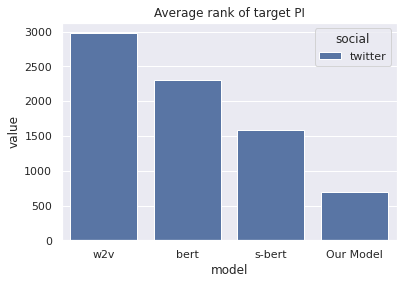

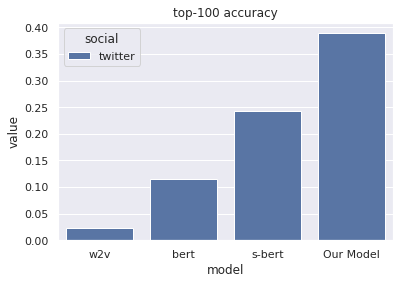

In [35]:
import pandas as pd

total = len(bio_y)
df_avg_rank = pd.DataFrame({
    'value': [w2v_avg_rank.item(), bert_avg_rank, sbert_avg_rank, fint_avg_rank],#, bert_avg_rank, sbert_avg_rank, fint_avg_rank],
    'social': ['twitter', 'twitter', 'twitter', 'twitter'],#, 'wiki', 'wiki', 'wiki'],
   'model': ['w2v', 'bert', 's-bert', 'Our Model']#, 'bert', 's-bert', 'Our Model',]
})

df_top_100 = pd.DataFrame({
    'value': [
        w2v_top100/total, bert_top100/total, sbert_top100/total, fint_top100/total,
        #bert_top100/wiki_tot, sbert_top100/wiki_tot, fint_top100/wiki_tot
    ],
    'social': ['twitter','twitter', 'twitter', 'twitter'],#, 'wiki', 'wiki', 'wiki'],
    'model': ['w2v', 'bert', 's-bert', 'Our Model']#, 'bert', 's-bert', 'Our Model',]
})


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

sns.barplot(data=df_avg_rank, x='model', y='value', hue='social')
plt.title('Average rank of target PI')
plt.show()

sns.barplot(data=df_top_100, x='model', y='value', hue='social')
plt.title('top-100 accuracy')
plt.show()

In [36]:
df_avg_rank.to_parquet('twitter_avg_rank.parquet')
df_top_100.to_parquet('twitter_top100.parquet')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
total_samples = len(bio_x)

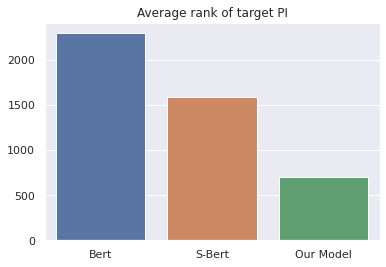

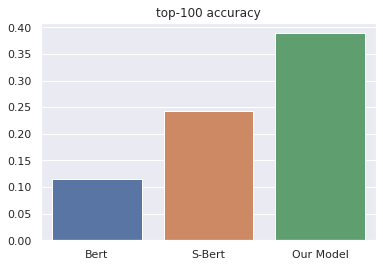

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
total_samples = len(bio_x)

sns.barplot(x=['Bert', 'S-Bert', 'Our Model'], y=[bert_avg_rank, sbert_avg_rank, fint_avg_rank])
plt.title('Average rank of target PI')
plt.show()

sns.barplot(x=['Bert', 'S-Bert', 'Our Model'], y=[bert_top100/total_samples, sbert_top100/total_samples, fint_top100/total_samples])
plt.title('top-100 accuracy')
plt.show()

# build survey questions

## neighborhood score + negative sampling choices

In [ ]:
import pandas as pd
from ast import literal_eval

df = pd.read_csv('twitter_pi_with_neighbors_tfidf.csv')
print(df.head())
df.positives = df.positives.apply(literal_eval)
df.negatives = df.negatives.apply(literal_eval)

In [ ]:
from tqdm import tqdm
from random import randint

pis = df['pis']
positives = df['positives']
negatives = df['negatives']

sample_cnt = 500
questions = []
targets = []
other_choices = []

sample_idices = np.random.randint(0, len(df), size=sample_cnt)

for qid in sample_idices:
    q = pis[qid]
    cur_pos = positives[qid]
    cur_neg = negatives[qid]
    target = cur_pos[randint(0,len(cur_pos)-1)]
    targets.append(target)
    questions.append(q)
    other_choices.append(np.random.choice(cur_neg, size=3, replace=False))
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('surrvey_tfidf_twitter.csv', index=False, header=True)

In [ ]:
!head surrvey_tfidf_twitter.csv -n 100

## model based question generation

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

fint_model = SentenceTransformer('./models/miniLM-L6-finetuned/')

In [ ]:
from tqdm import tqdm
from random import randint


all_pis = df['pis']
sims = df['similars']
sample_cnt = 500

questions = []
targets = []
other_choices = []

i = 0
while i < sample_cnt:
    idx = randint(0, len(all_pis)-1)
    questions.append(all_pis[idx])
    i += 1



In [ ]:
fint_emb_x = fint_model.encode(questions, convert_to_tensor=True)
fint_emb_all = fint_model.encode(all_pis, convert_to_tensor=True)


In [ ]:
import numpy as np

targets = []
other_choices = []

for x in tqdm(fint_emb_x):
    cosine_scores = util.cos_sim(x, fint_emb_all).detach().cpu().numpy()[0]
    argsort = np.argsort(cosine_scores)
    best_k = argsort[-6:-1]
    worst_k = argsort[:len(argsort)//2]
    
    target_idx = np.random.choice(best_k)
    targets.append(all_pis[target_idx])
    
    other_idxs = np.random.choice(worst_k, size=3, replace=False)
    other_choices.append([all_pis[x] for x in other_idxs])
    
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('modelbased-selection.csv', index=False, header=True)
    

In [ ]:
!head modelbased-selection.csv